In this notebook we extract the features of the map we are interested in (`de_dust2`), to do so we take advantage of the `awpy` library and the navmesh data it exposes

In [13]:
from matplotlib import pyplot as plt
from awpy.data import NAV
import numpy as np
import pickle

Since we want to split the map into a grid, we first find its bounds

In [3]:
minX = np.inf
maxX = -np.inf
minY = np.inf
maxY = -np.inf

smallestXDiff = np.inf
smallestYDiff = np.inf

for area in NAV["de_dust2"]:
    assert(NAV["de_dust2"][area]["northWestY"] < NAV["de_dust2"][area]["southEastY"])
    assert(NAV["de_dust2"][area]["northWestX"] < NAV["de_dust2"][area]["southEastX"])

    if NAV["de_dust2"][area]["northWestX"] < minX:
        minX = NAV["de_dust2"][area]["northWestX"]
    if NAV["de_dust2"][area]["southEastX"] > maxX:
        maxX = NAV["de_dust2"][area]["southEastX"]

    if NAV["de_dust2"][area]["northWestY"] < minY:
        minY = NAV["de_dust2"][area]["northWestY"]
    if NAV["de_dust2"][area]["southEastY"] > maxY:
        maxY = NAV["de_dust2"][area]["southEastY"]

    xdiff = NAV["de_dust2"][area]["southEastX"] - NAV["de_dust2"][area]["northWestX"]
    ydiff = NAV["de_dust2"][area]["southEastY"] - NAV["de_dust2"][area]["northWestY"]

    if xdiff < smallestXDiff:
        smallestXDiff = xdiff
    if ydiff < smallestYDiff:
        smallestYDiff = ydiff

print(minX, maxX, minY, maxY)
    

-2225.0 1800.0 -1175.0 3125.0


Now we do some definitions which will come useful in the next cell.

In [5]:
import math

def dist(x1,y1,x2,y2):
    return ((x1 - x2)**2 + (y1 - y2)**2)**.5

def z_at(x,y):
    for area in NAV["de_dust2"]:
        if 1e-4 >= abs(NAV["de_dust2"][area]["northWestX"] - x):
            if 1e-4 >= abs(NAV["de_dust2"][area]["northWestY"] - y):
                return NAV["de_dust2"][area]["northWestZ"]
        if 1e-4 >= abs(NAV["de_dust2"][area]["southEastX"] - x):
            if 1e-4 >= abs(NAV["de_dust2"][area]["southEastY"] - y):
                return NAV["de_dust2"][area]["southEastZ"]
    return None


This next cell goes through all points in a hex-grid pattern over the bounds we calculated previously, for each of these points it calculates the z following the heuristics described in the docs for each area the points are close to/intersect with.

In [6]:
points = dict()
bad_area = set()

# 2 m = 104.9... in csgo
unit = 105.0
half = unit * 0.5

minX = math.floor(minX)
maxX = math.ceil(maxX) + half
minY = math.floor(minY)
maxY = math.ceil(maxY) + half

x = minX
y = minY

half_iter = 0

x_step = unit * 0.866025

# Brute mode: activated, O(n^3) time
while x < maxX:
    x += x_step
    while y < maxY:
        y += unit
        distances = list()
        for area in NAV["de_dust2"]:
            if NAV["de_dust2"][area]['areaName'] == "":
                continue
            west = NAV["de_dust2"][area]["northWestX"]
            east = NAV["de_dust2"][area]["southEastX"]
            north = NAV["de_dust2"][area]["northWestY"]
            south = NAV["de_dust2"][area]["southEastY"]

            width = east - west
            height = south - north

            mid_x = width * 0.5 + west
            mid_y = height * 0.5 + north
            hy = ((width**2 + height**2)**0.5) * 0.5
            if dist(x,y, mid_x, mid_y) > hy + half * 1.1:
                continue

            x_to_use = 0
            y_to_use = 0
            curr_dist = np.inf

            if x < west:
                x_to_use = west
                if y < north:
                    curr_dist = dist(x,y,west,north)
                    y_to_use = north
                elif y >= south:
                    curr_dist = dist(x,y,west,south)
                    y_to_use = south
                else:
                    curr_dist = dist(x,y,mid_x,mid_y) - height * dist(x,y,mid_x,mid_y) / abs(y - mid_y) * 0.5
                    y_to_use = south + width * 0.5 * (y - mid_y) / (x - mid_x)
            elif x >= east:
                x_to_use = east
                if y < north:
                    curr_dist = dist(x,y,east,north)
                    y_to_use = north
                elif y >= south:
                    curr_dist = dist(x,y,east,south)
                    y_to_use = south
                else:
                    curr_dist = dist(x,y,mid_x,mid_y) - height * dist(x,y,mid_x,mid_y) / abs(y - mid_y) * 0.5
                    y_to_use = south + width * 0.5 * (y - mid_y) / (x - mid_x)
            else:
                curr_dist = dist(x,y,mid_x,mid_y) - width * dist(x,y,mid_x,mid_y) / abs(x - mid_x) * 0.5
                x_to_use = east + height * 0.5 * (x - mid_x) / (y - mid_y)
                if y < north:
                    y_to_use = north
                elif y >= south:
                    y_to_use = south
                else:
                    x_to_use = x
                    y_to_use = y
                    curr_dist = 0
            
            if abs(curr_dist) <= half * 0.5:
                distances.append((abs(curr_dist), area, x_to_use, y_to_use))
        
        distances.sort()

        ao = False
        for curr_dist, area, x_to_use, y_to_use in distances:
            if ao and curr_dist > 1e-6:
                break
            
            ao = True
            west = NAV["de_dust2"][area]["northWestX"]
            east = NAV["de_dust2"][area]["southEastX"]
            north = NAV["de_dust2"][area]["northWestY"]
            south = NAV["de_dust2"][area]["southEastY"]

            width = east - west
            height = south - north

            mid_x = width * 0.5 + west
            mid_y = height * 0.5 + north
            hy = ((width**2 + height**2)**0.5) * 0.5
            
            zsw = z_at(west, south)
            zne = z_at(east, north)

            mid_z = (NAV["de_dust2"][area]["northWestZ"] + NAV["de_dust2"][area]["southEastZ"]) * 0.5

            if zsw == None and zne == None:
                bad_area.add(area)
                zsw = zne = mid_z
            elif zsw == None:
                zsw = 2 * mid_z - zne
            elif zne == None:
                zne = 2 * mid_z - zsw

            z = 0
            
            d1 = dist(x_to_use,y_to_use,east,south)
            d2 = dist(x_to_use,y_to_use,west,north)
            if 1e-4 >= d1:
                z = NAV["de_dust2"][area]["southEastZ"]
            elif 1e-4 >= d2:
                z = NAV["de_dust2"][area]["northWestZ"]
            else:
                w1 = 1 / d1
                w2 = 1 / d2
                w3 = 0
                z3 = 0
                dist_ne = dist(x_to_use,y_to_use,east,north)
                dist_sw = dist(x_to_use,y_to_use,west,south)
                if 1e-4 >= dist_ne:
                    z = zne
                elif 1e-4 >= dist_sw:
                    z = zsw
                else:
                    if dist_ne < dist_sw:
                        w3 = 1 / dist_ne
                        z3 = zne
                    else:
                        w3 = 1 / dist_sw
                        z3 = zsw

                    # Top computer graphics knowledge
                    z = (w1 * NAV["de_dust2"][area]["southEastZ"] + w2 * NAV["de_dust2"][area]["northWestZ"] + w3 * z3) / (w1 + w2 + w3)
            
            tup = (x,y)

            if lst := points.get(tup, None):
                lst.append((z,NAV["de_dust2"][area]['areaName']))
            else:
                points[tup] = [(z,NAV["de_dust2"][area]['areaName'])]
    half_iter = (half_iter + 1) % 2
    y = minY + half * half_iter

print(len(bad_area))

C:\Users\surre\AppData\Local\Temp\ipykernel_12496\836689293.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  x_to_use = east + height * 0.5 * (x - mid_x) / (y - mid_y)
C:\Users\surre\AppData\Local\Temp\ipykernel_12496\836689293.py:56: RuntimeWarning: divide by zero encountered in double_scalars
  curr_dist = dist(x,y,mid_x,mid_y) - height * dist(x,y,mid_x,mid_y) / abs(y - mid_y) * 0.5
C:\Users\surre\AppData\Local\Temp\ipykernel_12496\836689293.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  curr_dist = dist(x,y,mid_x,mid_y) - height * dist(x,y,mid_x,mid_y) / abs(y - mid_y) * 0.5


27


As you can see the count spit out from this previous cell is just 27, it may seem bad but actually we have lots of areas (1000 or so if we remember correctly), not to mention that we've got both heuristics and our own ability to manually correct possible miscalculations!

What we now do in this next cell is applying (yet another) heuristic (described again in the docs): for each point we gather the areas we found for it and decide (with the help of the user in case, but fortunately there is no need with all we did) what to do.

In [7]:
points_area = list()
points_list = list()
for (x,y), lst in points.items():
    if len(lst) <= 1:
        points_list.append((x,y,lst[0][0]))
        points_area.append(lst[0][1])
        continue

    areanames = {tup[1] for tup in lst}
    possibilities = list()
    for area in {tup[1] for tup in lst}:
        k = [tup[0] for tup in lst if tup[1] == area]
        possibilities.append((sum(k) / len(k), area, len(k)))

    if len(possibilities) <= 1:
        points_list.append((x,y,possibilities[0][0]))
        points_area.append(possibilities[0][1])
        continue
    elif len(possibilities) == 2:
        if abs(possibilities[0][0] - possibilities[1][0]) > 90:
            points_list.append((x,y,possibilities[0][0]))
            points_area.append(possibilities[0][1])
            points_list.append((x,y,possibilities[1][0]))
            points_area.append(possibilities[1][1])
        elif possibilities[0][0] < possibilities[1][0]:
            points_list.append((x,y,possibilities[0][0]))
            points_area.append(possibilities[0][1])
        else:
            points_list.append((x,y,possibilities[1][0]))
            points_area.append(possibilities[1][1])
    else:
        accept = set()
        display(x,y,possibilities)
        j = 'n'
        stop = False
        while True:
            j = input("select: ")
            if j == 'k':
                break
            elif j == 's':
                stop = True
                break
            else:
                accept.add(int(j))
        
        if stop:
            break
        
        for i in accept:
            points_list.append((x,y,possibilities[i][0]))
            points_area.append(possibilities[i][1])


sort_ver = sorted(zip(points_list, points_area))
points_list = [list(item[0]) for item in sort_ver]
points_area = [item[1] for item in sort_ver]

to_store = (points_list, points_area)

with open('orig_extraction_AAA.pickle', 'wb') as handle:
    pickle.dump(to_store, handle, protocol=pickle.HIGHEST_PROTOCOL)


print(len(points_list))

A first extraction of the grid is done: let's give a look at it.

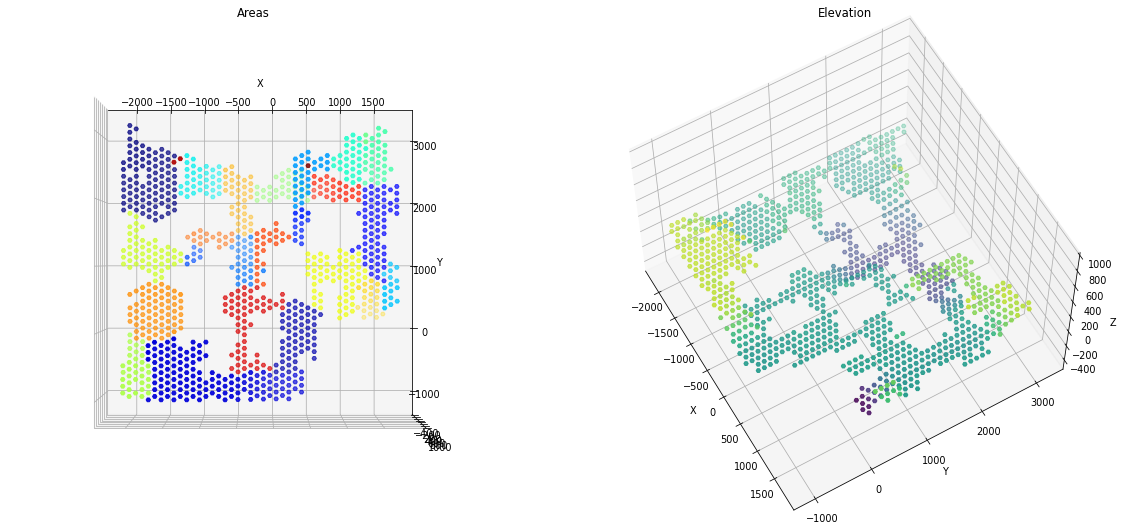

In [9]:
azim = -30
elev = 60

np_points = np.array(points_list).T

areas = list(frozenset(points_area))

point_area_indexes = [areas.index(area) for area in points_area]

fig = plt.figure(figsize=(20,40), dpi=70)
gs = fig.add_gridspec(1,2)
ax = gs.subplots(subplot_kw=dict({"projection": "3d"}))
ax[0].scatter(np_points[0], np_points[1], np_points[2], c=point_area_indexes, cmap="jet", marker="H")

ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_zlabel("")
ax[0].set_zlim(-500, 1000)

ax[0].azim = -90
ax[0].elev = 90
ax[0].set_title("Areas")

ax[1].scatter(np_points[0], np_points[1], np_points[2], c=np_points[2], cmap="viridis", marker="H")

ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].set_zlabel('Z')
ax[1].set_zlim(-500, 1000)

ax[1].azim = azim
ax[1].elev = elev
ax[1].set_title("Elevation")

plt.show()

As we can see this is really rough (someone who plays the game would probably understand more), exceptionally so around the edges of buildings.

What we do now (actually, what we did in the past by hands and now have left as hard-coded modifications) is applying a bunch of manual corrections to the extraction.

In [10]:
# Manual Adjustments

points_list.append([1230.439749999999, 767.5 - unit, 4.605101210734709])
points_area.append("LongDoors")
points_list.append([1230.439749999999, 767.5 - unit * 2, 4.605101210734709])
points_area.append("LongDoors")
points_list.append([1230.439749999999, 767.5 - unit * 3, 4.605101210734709])
points_area.append("LongDoors")

points_list.append([593.9113749999992 + x_step, -177.5, -0.2899059072546975])
points_area.append("OutsideLong")
points_list.append([593.9113749999992 + x_step, -177.5 - unit, -0.2899059072546975])
points_area.append("OutsideLong")

# First block
points_area.pop(815)
points_list.pop(815)
points_area.pop(814)
points_list.pop(814)
# Second block
points_area.pop(49)
points_list.pop(49)
# 3rd block
points_area.pop(138)
points_list.pop(138)
points_area.pop(105)
points_list.pop(105)
# 4th block
points_area.pop(232)
points_list.pop(232)
points_area.pop(132)
points_list.pop(132)
points_area.pop(30)
points_list.pop(30)
# 5th block
points_area.pop(404)
points_list.pop(404)
points_area.pop(372)
points_list.pop(372)
# 6th block
points_area.pop(402)
points_list.pop(402)
# 7th block
points_area.pop(350)
points_list.pop(350)
points_area.pop(349)
points_list.pop(349)

# 8th block
points_area.pop(395)
points_list.pop(395)
points_area.pop(394)
points_list.pop(394)
points_list.append([-679.145375000001, -755.0 + unit, 118.79788831965226])
points_area.append("TSpawn")

# 9th block
points_area.pop(504)
points_list.pop(504)
points_area.pop(478)
points_list.pop(478)
points_list.append([-224.48225000000085 - x_step, -492.5 + half, 1.3743454520265197])
points_area.append("TopofMid")

# 10th block
points_area.pop(582)
points_list.pop(582)

# 11th block
points_area.pop(687)
points_list.pop(687)
points_list.append([-42.61700000000084, -597.5 + unit, 0.03125])
points_area.append("TopofMid")
points_list.append([684.8439999999993, 242.5 - unit, 0.07792744730540382])
points_area.append("OutsideLong")
points_list.append([48.31562499999916, 400.0 - unit, -0.9909779092235633])
points_area.append("TopofMid")
points_list.append([-133.54962500000084, 715.0 - unit, 0.03125])
points_area.append("TopofMid")

# 12th block
points_area.pop(575)
points_list.pop(575)

# 13th block
points_area.pop(669)
points_list.pop(669)

# 14th block
points_list.append([-133.54962500000084, 715.0 + unit, 0.03125])
points_area.append("Catwalk")
points_list[527][2] = 0.03125
points_area[527] = "Catwalk"
points_list.append([-133.54962500000084, 1030.0 + unit, 0.03125])
points_area.append("Catwalk")

# 15th block
points_list.append([957.6418749999993, 505.0 + unit, 11.776490524509448])
points_area.append("LongDoors")
points_list.append([957.6418749999993, 505.0 + 2*unit, 11.776490524509448])
points_area.append("LongDoors")

# 16th block
points_area.pop(740)
points_list.pop(740)

# 17th block
points_area.pop(894)
points_list.pop(894)


# 18th block
points_list.append([1776.0354999999986, 977.5 - unit, 0.033361])
points_area.append("Side")
points_list.append([1776.0354999999986, 662.5 - unit, 56.031242])
points_area.append("Side")
points_list.append([1776.0354999999986, 662.5 - 3*unit, 56.031242])
points_area.append("Side")

# 19th block
points_area.pop(903)
points_list.pop(903)
points_area.pop(902)
points_list.pop(902)
points_area.pop(901)
points_list.pop(901)
points_list.append([1230.439749999999, 1817.5 + unit, 1.0679813062654704])
points_area.append("LongA")
points_list.append([1230.439749999999, 1817.5 - unit, 1.0679813062654704])
points_area.append("LongA")
points_list.append([1230.439749999999, 1817.5 - 2*unit, 1.0679813062654704])
points_area.append("LongA")
points_list.append([1230.439749999999, 1817.5 - 3*unit, 1.0679813062654704])
points_area.append("LongA")
points_list.append([1230.439749999999, 1817.5 - 4*unit, 1.0679813062654704])
points_area.append("LongA")
points_list.append([866.7092499999993, 977.5 + unit, -0.6837098608934693])
points_area.append("LongDoors")

# 20th block
points_area.pop(931)
points_list.pop(931)
points_area.pop(926)
points_list.pop(926)
points_area.pop(915)
points_list.pop(915)
points_area.pop(914)
points_list.pop(914)
points_area.pop(893)
points_list.pop(893)
points_list.append([1685.1028749999987, 2185.0 + unit, 1.0975448190559265])
points_area.append("LongA")

# 21st block
points_area.pop(675)
points_list.pop(675)
points_list.append([866.7092499999993, 2552.5 - unit, 110])
points_area.append("BombsiteA")
points_list.append([957.6418749999993, 2290.0 + unit, 8.858731913814207])
points_area.append("UnderA")
points_list.append([684.8439999999993, 2552.5 - unit, 110])
points_area.append("ExtendedA")
points_list.append([502.9787499999992, 1817.5 + unit, 96.03125])
points_area.append("ShortStairs")
points_list.append([502.9787499999992, 1712.5 - unit, 4.662296])
points_area.append("ShortStairs")
points_list.append([502.9787499999992, 1712.5 - 2*unit, 4.662296])
points_area.append("ShortStairs")

# 22nd block
points_area.pop(557)
points_list.pop(557)
points_list.append([-42.61700000000084, 1502.5 + unit, 0.03125])
points_area.append("Catwalk")

# 23rd block
points_area.pop(496)
points_list.pop(496)
points_area.pop(491)
points_list.pop(491)
points_list.append([-588.2127500000009, 1817.5 - unit, -115.21967666025157])
points_area.append("MidDoors")
points_list.append([-588.2127500000009, 1922.5 + unit, -119.75830709481063])
points_area.append("MidDoors")
points_list.append([48.31562499999916, 2395.0 + unit, -119.96874999999999])
points_area.append("CTSpawn")
points_list.append([-406.3475000000009, 2342.5 + unit, -105.27784873832827])
points_area.append("MidDoors")

# 24th block
points_area.pop(14)
points_list.pop(14)
points_list.append([-2134.067375, 2605.0 + unit, 31.52837801805372])
points_area.append("BombsiteB")
points_list.append([-2134.067375, 2605.0 + 2*unit, 31.52837801805372])
points_area.append("BombsiteB")
points_list.append([-2134.067375, 2605.0 + 3*unit, 31.52837801805372])
points_area.append("BombsiteB")
points_list.append([-2134.067375, 2605.0 + 4*unit, 31.52837801805372])
points_area.append("BombsiteB")
points_list.append([-2134.067375, 2605.0 + 5*unit, 31.52837801805372])
points_area.append("BombsiteB")

points_area[892] = "Side"
points_list[892][2] = 40

points_list[116][2] = 120
points_list[240][2] = 60
points_list[487][2] = -90

to_store = (points_list, points_area)

with open('cleaned_extraction_AAA.pickle', 'wb') as handle:
    pickle.dump(to_store, handle, protocol=pickle.HIGHEST_PROTOCOL)

Now that we've cleaned the extraction let's give another look at it!

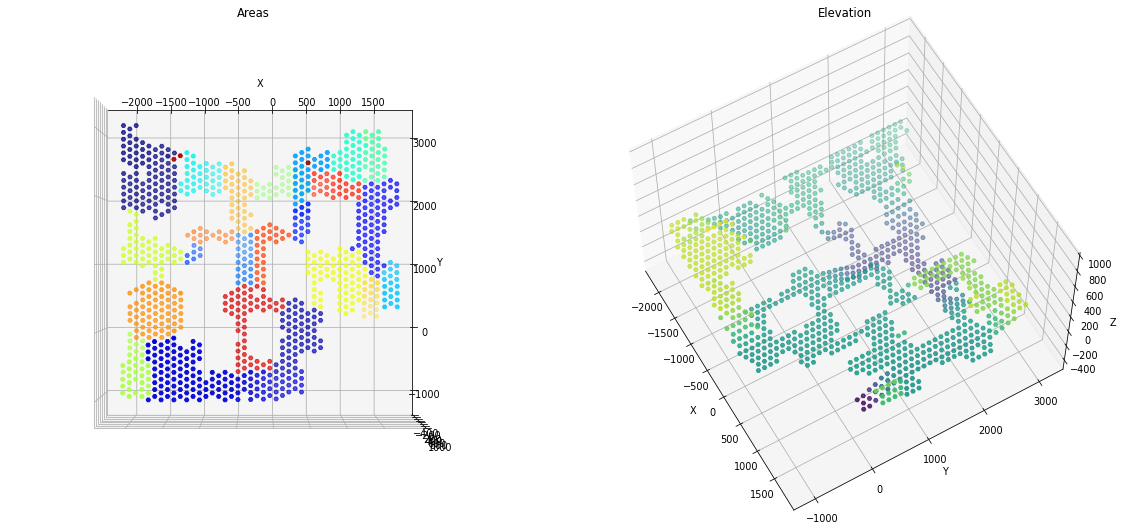

In [12]:
np_points = np.array(points_list).T

areas = list(frozenset(points_area))

point_area_indexes = [areas.index(area) for area in points_area]

fig = plt.figure(figsize=(20,40), dpi=70)
gs = fig.add_gridspec(1,2)
ax = gs.subplots(subplot_kw=dict({"projection": "3d"}))
ax[0].scatter(np_points[0], np_points[1], np_points[2], c=point_area_indexes, cmap="jet", marker="H")

ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_zlabel("")
ax[0].set_zlim(-500, 1000)

ax[0].azim = -90
ax[0].elev = 90
ax[0].set_title("Areas")

ax[1].scatter(np_points[0], np_points[1], np_points[2], c=np_points[2], cmap="viridis", marker="H")

ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].set_zlabel('Z')
ax[1].set_zlim(-500, 1000)

ax[1].azim = azim
ax[1].elev = elev
ax[1].set_title("Elevation")

plt.show()

That's more like it, the edges are now much better and some z's have been solved! Let's go to the next notebook with the making of the graph.